# 기계학습 (60점)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import koreanize_matplotlib
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR

### 전국 병의원 데이터
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m1.csv    
출처 : https://www.data.go.kr/data/15083033/fileData.do    
        
전국의 병의원 (치과의원,의원,한의원)의 정보이다.           
        

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m1.csv')
df.head(5)

,사업장명,업태구분명,진료과목내용명,도로명전체주소,인허가일자,상세영업상태명,폐업일자
0,효치과의원,치과의원,치과,"광주광역시 북구 동문대로 24, 3층 (풍향동)",1999-06-12,영업중,NaN
1,일곡부부치과의원,치과의원,치과,"광주광역시 북구 설죽로 518, 2층 (일곡동)",1999-07-07,영업중,NaN
2,사랑이가득한치과의원,치과의원,치과,"광주광역시 북구 설죽로 495, 3층 (일곡동)",1999-07-13,영업중,NaN
3,으뜸한의원,한의원,"한방내과, 한방부인과, 한방소아과, 한방안·이비인후·피부과, 한방신경정신과, 한방재...","광주광역시 북구 임방울대로 1063, 4층 (용두동)",1999-10-29,영업중,NaN
4,예일치과의원,치과의원,치과,"광주광역시 북구 설죽로 565, 2층 (일곡동, 한국아파트상가)",1999-12-21,영업중,NaN


### 기계학습2
진료과목내용명의 연관분석을 진행하려한다.     
업태를 의원,한의원,치과의원 각각 나누어 데이터 전처리 및 트랜잭션 변환을 진행하라

In [5]:
#!pip install mlxtend

In [3]:
from mlxtend.preprocessing import TransactionEncoder

trans_dic = {}

te = TransactionEncoder()
for name, group in df.groupby('업태구분명') :
  transaction = group['진료과목내용명'].apply(lambda x : x.split(',')).tolist()
  te_ary = te.fit(transaction).transform(transaction)
  te_df = pd.DataFrame(te_ary, columns = te.columns_)
  trans_dic[name] = te_df

### 기계학습3
업태별로 연관 규칙 생성 및 평가 지표 계산을 진행하라    

In [4]:
# trans_dic 사용
from mlxtend.frequent_patterns import apriori, association_rules

for name, value in trans_dic.items() :
  frequent = apriori(value,
                     min_support=  0.1 ,
                     use_colnames= True)  #Antecdents와 Consequents의 이름 표시

  rules = association_rules(frequent,
                            metric= 'confidence' ,
                            min_threshold= 0.1)
  result = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
result

,antecedents,consequents,support,confidence,lift
0,( 사상체질과),( 침구과),0.729517,0.989396,1.100238
1,( 침구과),( 사상체질과),0.729517,0.811245,1.100238
2,( 한방부인과),( 사상체질과),0.731839,0.804626,1.091262
3,( 사상체질과),( 한방부인과),0.731839,0.992545,1.091262
4,( 한방소아과),( 사상체질과),0.731934,0.808268,1.096200
...,...,...,...,...,...
6045,( 한방부인과),"( 한방소아과, 한방신경정신과, 침구과, 한방안·이비인후·피부과, 한방내과, ...",0.691466,0.760238,1.098404
6046,( 한방안·이비인후·피부과),"( 한방소아과, 한방신경정신과, 침구과, 한방부인과, 한방내과, 한방재활의학...",0.691466,0.786122,1.134017
6047,(한방내과),"( 한방소아과, 한방신경정신과, 침구과, 한방부인과, 한방안·이비인후·피부과...",0.691466,0.700528,1.011166
6048,( 한방재활의학과),"( 한방소아과, 한방신경정신과, 침구과, 한방부인과, 한방안·이비인후·피부과...",0.691466,0.882118,1.254995


### 서울의 미세먼지 데이터
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m2.csv    
출처 : https://www.data.go.kr/data/15089266/fileData.do
        
2020년~ 2022년도의 서울 각 지역구의 시간별    
미세먼지(pm10)와 초미세먼지(pm25)데이터이다.         
하루동안의 미세먼지(pm10)와 지역구,시간 정보를 바탕으로 다음날 00:00시의 해당 지역구의 초미세먼지(pm25)를      
예측하는 회귀 모델을 만들려고 한다.   

In [6]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m2.csv')

In [7]:
df['일시'] = pd.to_datetime(df['일시']).dt.date
df.head(4)

,일시,구분,pm10,pm25,date,hour
0,2022-12-31,강남구,57.0,44.0,2022-12-31,23
1,2022-12-31,강동구,68.0,55.0,2022-12-31,23
2,2022-12-31,강북구,59.0,42.0,2022-12-31,23
3,2022-12-31,강서구,62.0,40.0,2022-12-31,23


### 기계학습5
시각화를 포함한 EDA

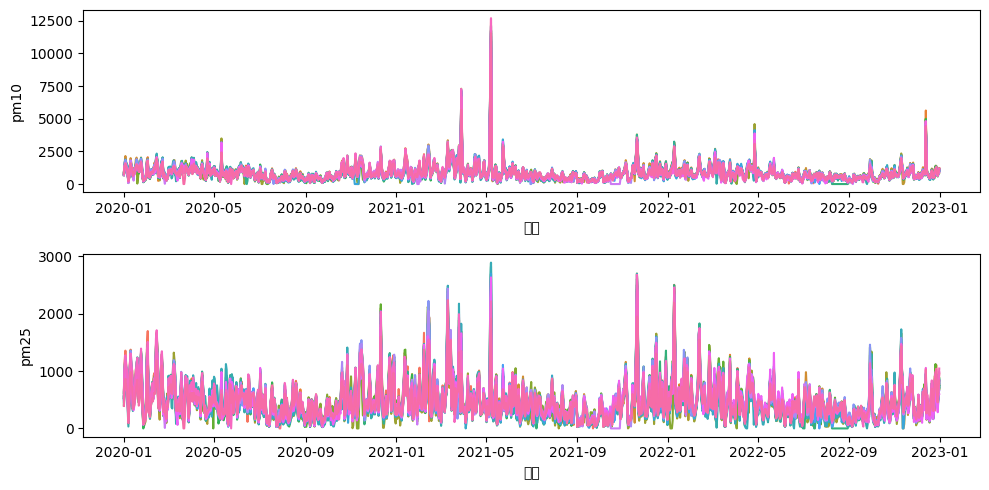

In [8]:
target = df.groupby(['일시','구분']).agg({'pm10': 'sum', 'pm25': 'sum'}).reset_index()

fig, axes = plt.subplots(2, 1, figsize = (10, 5))
sns.lineplot(x = '일시', y = 'pm10' , hue = '구분' , data = target, ax = axes[0])
sns.lineplot(x = '일시', y = 'pm25' , hue = '구분' , data = target, ax = axes[1])

axes[0].legend().remove()
axes[1].legend().remove()

plt.tight_layout()
plt.show()

### 기계학습6
모델링을 위한 데이터 전처리 및 결측치 처리를 시행하라    
독립변수는 a일자의 지역구, 각 시간대별 pm10값이며    
종속변수는 a+1일자의 00:00시의 해당 지역구의 pm25 값이다      
아래는 예시이다.    
![img](https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m1_img.png)

In [9]:
pivot_df = df.pivot_table(index = ['일시','구분'], columns = 'hour' , values = 'pm10').reset_index()
pivot_df.head(4)

hour,일시,구분,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,2020-01-01,강남구,19.0,32.0,28.0,20.0,20.0,20.0,20.0,21.0,...,32.0,36.0,36.0,36.0,37.0,39.0,39.0,42.0,41.0,43.0
1,2020-01-01,강동구,27.0,25.0,25.0,25.0,24.0,28.0,27.0,28.0,...,39.0,40.0,41.0,42.0,44.0,51.0,50.0,52.0,49.0,51.0
2,2020-01-01,강북구,21.0,32.0,30.0,33.0,29.0,35.0,32.0,33.0,...,41.0,45.0,48.0,50.0,50.0,51.0,48.0,50.0,50.0,55.0
3,2020-01-01,강서구,23.0,29.0,25.0,27.0,27.0,35.0,26.0,30.0,...,39.0,46.0,45.0,46.0,47.0,51.0,46.0,52.0,47.0,52.0


In [10]:
#  a+1일자의 00:00시의 해당 지역구의 pm25
import datetime
# 1/1의 다음날 > 1/2일 00시는
df_24 = df.loc[df['hour'] == 0 ][['일시','구분','pm25']].sort_values(by= ['구분','일시']).reset_index(drop = True)

df_24['date_delta'] = df_24['일시'] - datetime.timedelta(days = 1)
df_24 = df_24[['date_delta','구분','pm25']]
df_24.head(5)

,date_delta,구분,pm25
0,2019-12-31,강남구,13.0
1,2020-01-01,강남구,32.0
2,2020-01-02,강남구,51.0
3,2020-01-03,강남구,43.0
4,2020-01-04,강남구,33.0


In [34]:
# 2020-01-01의 다음날인 01-02의 데이터가 2020-01-01의 값으로 들어가야함 
df.loc[df['hour'] ==0][['일시','구분','pm25']].sort_values(by= ['구분','일시']).reset_index(drop = True).head(4)

,일시,구분,pm25
0,2020-01-01,강남구,13.0
1,2020-01-02,강남구,32.0
2,2020-01-03,강남구,51.0
3,2020-01-04,강남구,43.0


In [18]:
f_df = pd.merge(pivot_df, df_24, how  = 'inner', left_on = ['일시','구분'] ,  right_on = ['date_delta','구분'])
f_df = f_df.drop(columns = ['date_delta'] , axis = 1)
f_df.columns.name = ''
f_df.columns = [col if str(col) in ['일시','구분','pm25'] else str(col) + '시' for col in f_df.columns]

for col in f_df.columns : 
    if f_df[col].isna().sum() > 0 : 
        f_df[col] = f_df[col].fillna(method = 'bfill')

In [20]:
# f_df.isna().sum()

### 기계학습7
3가지 회귀 분석 모델을 선정하고 선정이유를 설명하라. 각 모델을 kfold 방식을 통해 학습하고 적절한 평가지표를 통해 모델을 평가하라.   

In [29]:
X = f_df.drop(columns = ['일시','구분'], axis = 1)
y = f_df['pm25']

def model_val(name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.3 , random_state = 42)

    # Kfold - 데이터 나누고 적용 
    kfold = KFold(n_splits=3, shuffle = True, random_state = 42)
    cv = cross_val_score(model, x_train, y_train, cv = kfold , scoring = 'neg_mean_squared_error')
    score = np.mean(cv)

    #Model
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    #score
    mse = np.sqrt(mean_squared_error(y_test, pred))

    return name, score, mse 

res = []
for name, model in [['LR', LinearRegression()], ['RF',RandomForestRegressor()] , ['SVR' , SVR()]] : 
    name, score, mse  = model_val(name, model)
    res.append([name, score, mse ])

result = pd.DataFrame(res, columns = ['Model','K_fold_score','MSE'])
result

,Model,K_fold_score,MSE
0,LR,-1.457165e-26,1.082948e-13
1,RF,-5.237366e-01,1.256522e+00
2,SVR,-2.641269e+01,6.983639e+00


### 기계학습8
7번에서 가장 높은 스코어를 가진 모델 하나를 선정하여 최적화 과정을 하려한다. grid search를 통해 모델을 학습하여 성능을 비교하라

In [31]:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state = 42)

rf = RandomForestRegressor()

params = {
    'n_estimators' : [1,10,20,100],
    'max_depth' : [2,4,6,7],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' :[1,3,5],
}

grid = GridSearchCV(rf, params, cv = 3, scoring = 'neg_mean_squared_error') 
grid.fit(x_train, y_train) 

grid_pred = grid.predict(x_test)

mse = np.sqrt(mean_squared_error(y_test, grid_pred))
print(mse)

1.5288679769177709


# 통계 (40점)

### 통계1
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s1.csv    
출처 : https://www.data.go.kr/data/15083033/fileData.do    
    
지역별 헬스장의 인허가 일자 및 폐업일자에 관한 데이터이다(2025-02-29일에 조사된 데이터라고 가정한다)    
수도권(서울,경기도)과 지방(그 외)의 인허가 후 365일 이내 폐업 여부가 연관이 있는지 확인하려한다.    
(1) 가설설정     
(2) 통계 검정

In [32]:
import pandas as pd

In [103]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s1.csv')
df.head()

,인허가일자,폐업일자,상세영업상태명,소재지전체주소,사업장명
0,2014-09-24,NaN,영업중,대구광역시 달성군 다사읍 죽곡리 808-1번지 2~3층,슬림 휘트니스 클럽
1,2016-05-02,NaN,영업중,대구광역시 달성군 화원읍 구라리 1737-14번지 4층,다짐휘트니스
2,2016-05-09,NaN,영업중,대구광역시 달성군 옥포읍 교항리 2902번지,디젤 피트니스
3,2016-12-13,NaN,영업중,대구광역시 달성군 유가읍 봉리 606 하이젠스타 9층,뷰스 짐
4,2017-01-04,NaN,영업중,대구광역시 달성군 다사읍 세천리 1580-9번지 3층,다짐휘트니스


In [104]:
## 수도권 처리 
df['수도권여부'] = df['소재지전체주소'].apply(lambda x : '수도권' 
                                          if any(s in x for s in ['서울특별시','경기도']) else '지방')



df['수도권여부'].value_counts()

수도권여부
수도권    10782
지방     10692
Name: count, dtype: int64

In [105]:
df['diff'] = (pd.to_datetime(df['폐업일자']) - pd.to_datetime(df['인허가일자'])).dt.days

In [106]:
# 인허가 후 365일 이내 폐업 여부가 연관 
df['폐업여부'] = np.where(
                            (df['diff'] < 366) & (df['상세영업상태명'] =='폐업') , '폐업', '영업'
                        )
pd.crosstab(df.수도권여부,df.상세영업상태명)

상세영업상태명,영업중,폐업
수도권여부,,
수도권,7284,3498
지방,7212,3480


In [107]:
# 귀무가설 : 폐업여부와 수도권 여부는 관계가 없다
# 대립가설 : 폐업여부와 수도권 여부는 관계가 있다. 
from scipy.stats import chi2_contingency, shapiro, levene

tab = pd.crosstab(df.수도권여부,df.상세영업상태명) 
stat, p_val, _ , _ = chi2_contingency(tab)
print(p_val)

0.881330944673242


### 통계2
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s2.csv    
출처 : https://www.data.go.kr/data/15083033/fileData.do    
    
여러 치킨 브랜드의 데이터이다(치킨브랜드는 사업장명에 반드시 대표 브랜드명이 들어가야한다)           
2017~ 2022년도에 인허가가 발생한 굽네치킨,교촌치킨,네네치킨,자담치킨 영업장의 시설총규모간의 차이가 브랜드별로 존재하는지 확인하려 한다.         
(1) ANOVA를 사용 하기 위한 사전 조건들을 확인 하라         
(2) 적당한 통계 검정을 실시 하고 필요하다면 사후 분석까지 진행하라    

In [108]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s2.csv')
df.head()

,인허가일자,사업장명,업태구분명,시설총규모,업체ID
0,2023-11-24,자담치킨,한식,186.00,ID_0
1,2023-09-27,네네치킨&봉구스밥버거 안동과학대점,호프/통닭,25.00,ID_1
2,2023-10-11,교촌치킨 봉천3호점,기타,72.00,ID_2
3,2019-01-09,맘스터치,분식,38.78,ID_3
4,2022-05-10,노랑통닭,호프/통닭,26.10,ID_4


In [109]:
def get_brand_code(name):
    if "굽네치킨" in name:
        return '굽네치킨'
    elif "교촌치킨" in name:
        return '교촌치킨'
    elif "네네치킨" in name:
        return '네네치킨'
    elif "자담치킨" in name:
        return '자담치킨'
    else:
        return np.nan

# apply 함수를 사용하여 새 칼럼에 브랜드 코드 할당
df['brand'] = df['사업장명'].apply(get_brand_code)
df.head()

,인허가일자,사업장명,업태구분명,시설총규모,업체ID,brand
0,2023-11-24,자담치킨,한식,186.00,ID_0,자담치킨
1,2023-09-27,네네치킨&봉구스밥버거 안동과학대점,호프/통닭,25.00,ID_1,네네치킨
2,2023-10-11,교촌치킨 봉천3호점,기타,72.00,ID_2,교촌치킨
3,2019-01-09,맘스터치,분식,38.78,ID_3,NaN
4,2022-05-10,노랑통닭,호프/통닭,26.10,ID_4,NaN


In [110]:
# 방법 2) 
#df['사업장명'].str.extract('(굽네치킨|교촌치킨|네네치킨|자담치킨)')

In [118]:
# NaN이 아닌것만 추출 
f_df = df.loc[~ pd.isna(df['brand'])]

target= f_df[['brand','시설총규모']]

# 1. 정규성 검정 
res= []
for key, group in target.groupby('brand') : 
    stat, p_val = shapiro(group['시설총규모'])
    res.append({
        'Brand' : key, 
        'p_val' : p_val, 
        'Decision' : '정규분포가 아니다' if p_val < 0.05 else '정규분포이다'
    })

display(pd.DataFrame(res))

# 2.등분산 검정 
group = [group['시설총규모'] for name ,group in target.groupby('brand')]
stat, p_val = levene(* group)
print(p_val)

,Brand,p_val,Decision
0,교촌치킨,3.297140e-37,정규분포가 아니다
1,굽네치킨,3.015226e-39,정규분포가 아니다
2,네네치킨,1.386691e-41,정규분포가 아니다
3,자담치킨,1.563991e-29,정규분포가 아니다


1.1811595753193375e-135


,sum_sq,df,F,PR(>F)
brand,1.020384e+06,3.0,301.561193,9.315007e-182
Residual,6.451534e+06,5720.0,NaN,NaN


 Multiple Comparison of Means - Tukey HSD, FWER=0.50  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  교촌치킨   굽네치킨 -22.2116    0.0 -23.8327 -20.5904   True
  교촌치킨   네네치킨 -34.0616    0.0 -35.7012 -32.4221   True
  교촌치킨   자담치킨 -19.9157    0.0 -21.8297 -18.0016   True
  굽네치킨   네네치킨 -11.8501    0.0 -13.5887 -10.1114   True
  굽네치킨   자담치킨   2.2959 0.3751   0.2963   4.2955   True
  네네치킨   자담치킨   14.146    0.0  12.1314  16.1605   True
------------------------------------------------------


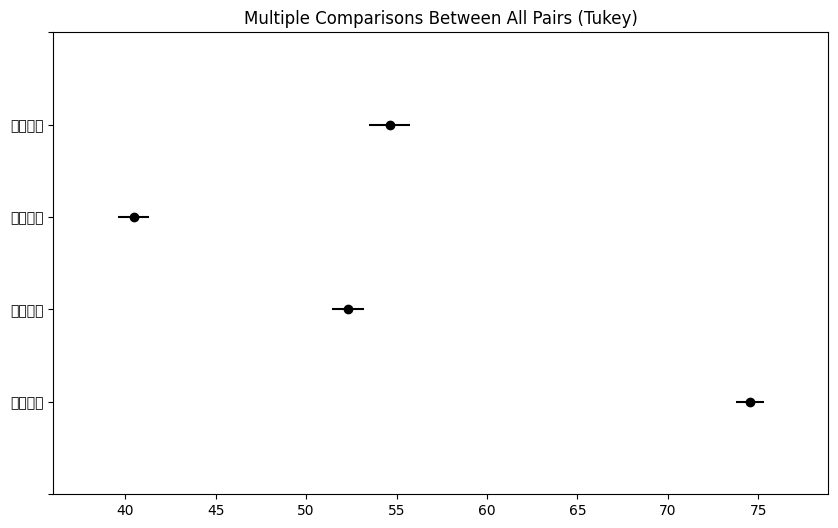

In [145]:
# 1. 모수일떄, ANOVA
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

model = ols('시설총규모 ~ brand', data = target).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
display(anova_table)

# Tukey (사후검정)
tukey = pairwise_tukeyhsd(target['시설총규모'] , target['brand'] , alpha = 0.5)
print(tukey.summary())

# TUkey plot 
tukey.plot_simultaneous()
plt.show()

In [131]:
# 비모수 대안 - Kruskal - Dunn 사후검정 
from scipy.stats import kruskal
import scikit_posthocs as sp 

groups = [group['시설총규모'] for name, group in target.groupby('brand')] 
stat, p_val = kruskal(*groups)
print(p_val)

# Dunn 사후검정 
dunn = sp.posthoc_dunn(target, val_col = '시설총규모', group_col = 'brand', p_adjust='bonferroni')
display(dunn)

1.380065021275104e-174


,교촌치킨,굽네치킨,네네치킨,자담치킨
교촌치킨,1.000000e+00,9.162136e-42,4.456258e-176,1.673028e-23
굽네치킨,9.162136e-42,1.000000e+00,1.051958e-43,1.000000e+00
네네치킨,4.456258e-176,1.051958e-43,1.000000e+00,2.901447e-40
자담치킨,1.673028e-23,1.000000e+00,2.901447e-40,1.000000e+00


### 통계3
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s3.csv    
출처 : https://vincentarelbundock.github.io/Rdatasets/datasets.html
    
각 행은 여러 요소들(A,C,E,N,O)의 정량적인 값을 의미한다

(1) 요인성분석을 통해 요인분석이 가능한지 확인하라     
(2) 요인분석을 통해 적정 요인수를 확인하고 탐색적 요인분석을 실시하라

In [132]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s3.csv')
df

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N2,N3,N4,N5,O1,O2,O3,O4,O5,ID
0,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,...,4.0,2.0,2.0,3.0,3.0,6,3.0,4.0,3.0,ID_0
1,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,...,3.0,3.0,5.0,5.0,4.0,2,4.0,3.0,3.0,ID_1
2,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,...,5.0,4.0,2.0,3.0,4.0,2,5.0,5.0,2.0,ID_2
3,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,...,5.0,2.0,4.0,1.0,3.0,3,4.0,3.0,5.0,ID_3
4,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,2.0,...,3.0,4.0,4.0,3.0,3.0,3,4.0,3.0,3.0,ID_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,3.0,4.0,3.0,1.0,3.0,5.0,4.0,5.0,3.0,4.0,...,6.0,5.0,5.0,6.0,6.0,1,4.0,5.0,2.0,ID_2431
2432,5.0,5.0,5.0,5.0,3.0,5.0,4.0,2.0,3.0,5.0,...,5.0,3.0,5.0,2.0,6.0,1,5.0,6.0,2.0,ID_2432
2433,2.0,3.0,5.0,2.0,5.0,5.0,5.0,5.0,1.0,1.0,...,4.0,3.0,3.0,1.0,5.0,1,6.0,4.0,3.0,ID_2433
2434,5.0,2.0,2.0,4.0,4.0,5.0,5.0,5.0,2.0,6.0,...,5.0,6.0,4.0,1.0,5.0,2,5.0,5.0,1.0,ID_2434


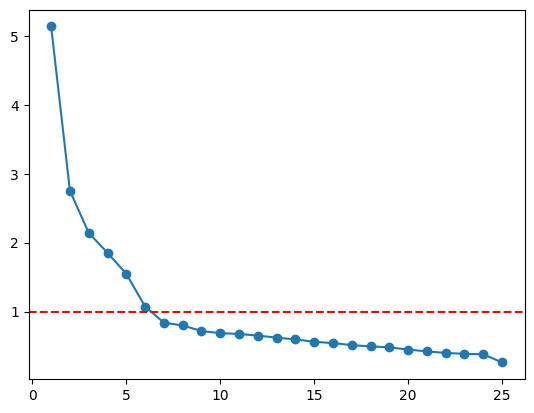


Eigen Value 1 이상인 지점 까지로 factor를 선정 총 6개 



In [148]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer

X = df.iloc[:,:-1]

#표준화 X 
scaled_x = pd.DataFrame(StandardScaler().fit_transform(X) , columns = X.columns) 

# Factor analysis 
fa =  FactorAnalyzer(n_factors=scaled_x.shape[1], rotation=None, method='ml')
fa.fit(scaled_x) 

# eigen value - Factor Analyzer 함수 호출해야함
ev, v = fa.get_eigenvalues()

plt.scatter(range(1, scaled_x.shape[1] + 1), ev)
plt.plot(range(1,scaled_x.shape[1]+1),ev)
plt.axhline(1, color = 'red', linestyle = '--')
plt.show()

print('''
Eigen Value 1 이상인 지점 까지로 factor를 선정 총 6개 
''')

### 통계4
두명의 운동선수가 2번의 경기동안 득점한 결과이다.      
(1) 두 선수의 실력이 동일 하다 말할 수 있는지 검정하라   
(2) 오즈비를 구하여라    

<table>
<tr>
    <th></th>
    <td>1경기</td>
    <td>2경기</td>
</tr>

<tr>
    <td>선수1</td>
    <td>10</td>
    <td>2</td>
</tr>

<tr>
    <td>선수2</td>
    <td>3</td>
    <td>6</td>   
</tr>

</table>  

In [159]:
from scipy.stats import fisher_exact 
import numpy as np 

data = np.array([[10,2], [3,6]])
data

odds_ratio , pval = stats.fisher_exact(data)
print(odds_ratio)

10.0


C:\Users\i2max-DoeunKim\AppData\Local\Temp\ipykernel_37148\756484563.py:7: DeprecationWarning: Please import `fisher_exact` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  odds_ratio , pval = stats.fisher_exact(data)
